# Бинарная классификация сетевого трафика: безопасный и вирусный.

Требуется определить является ли сетевое взаимодействие опасным/безопасным по большому числу признаков трафика. 

## Подключение модулей

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline              
import pandas as pd
import seaborn as sns
import sklearn

## Исправление проблем датасета
В исходном датасете в заголовках неравномерно стояли пробелы.

In [2]:
# file = open(url, "r")
# f = file.read()
# file.close()
# file = open(url, "w")
# f = f.replace(' ', '')
# file.write(f)
# file.close()

# Загрузка данных

In [3]:
url = './data/dataset.csv'
data = pd.read_csv(url, sep=',', header=0, engine='python')
data.shape

(177482, 85)

Датасет содержит 85 различных признаков, такие как IP, порт, размер пакета, число пакетов, скорость соединения и т.д. Классами являются метки Trojan - вирус и Benign - не вирус. Датасет содержит более 170 000 записей сетевых взаимодействий.

In [4]:
data = data.dropna()
data = data.drop("Timestamp", axis = 1)
data.shape

(177482, 84)

=> пропущенных значений нет

In [5]:
data.head()

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Class
73217,10.42.0.42-121.14.255.84-49975-80-6,10.42.0.42,49975,121.14.255.84,80,6,10743584,4,4,372.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
72089,172.217.6.226-10.42.0.42-443-49169-17,10.42.0.42,49169,172.217.6.226,443,17,254217,6,7,3191.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
96676,10.42.0.1-10.42.0.42-53-37749-17,10.42.0.42,37749,10.42.0.1,53,17,1023244,1,1,30.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
42891,10.42.0.1-10.42.0.42-53-41352-17,10.42.0.42,41352,10.42.0.1,53,17,286483,1,1,40.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
169326,10.42.0.151-107.22.241.77-44353-443-6,10.42.0.151,44353,107.22.241.77,443,6,65633087,12,10,767.0,...,32,322594.0,0.0,322594.0,322594.0,60306983.0,0.0,60306983.0,60306983.0,Benign


In [6]:
data.tail()

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Class
40740,10.42.0.42-64.71.142.96-60811-80-6,10.42.0.42,60811,64.71.142.96,80,6,40648037,2,0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
82587,10.42.0.42-54.192.36.60-33004-80-6,10.42.0.42,33004,54.192.36.60,80,6,2037177,2,0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
66647,172.217.9.232-10.42.0.42-443-51049-6,10.42.0.42,51049,172.217.9.232,443,6,397316,9,7,867.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
7987,10.42.0.211-10.42.0.1-9145-53-17,10.42.0.211,9145,10.42.0.1,53,17,32073,1,1,37.0,...,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
167491,10.42.0.42-104.254.66.16-47389-80-6,10.42.0.42,47389,104.254.66.16,80,6,360889,2,0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


## Основные характеристики и визуализация

Характеристик очень много, поэтому визуализирую некоторые из них.

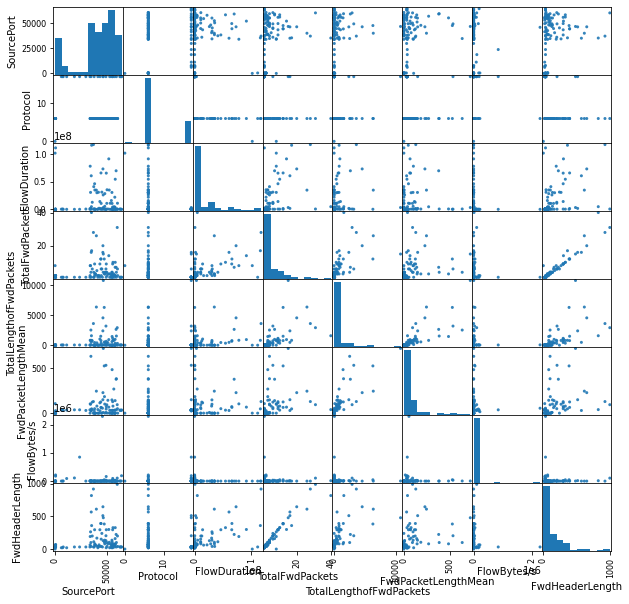

In [7]:
from pandas.plotting import scatter_matrix
headers = ['SourceIP', 'SourcePort', 'Protocol', 'FlowDuration', 'TotalFwdPackets', 'TotalLengthofFwdPackets', 'FwdPacketLengthMean', 'FlowBytes/s', 'FwdHeaderLength', 'Class']
scatter_matrix(data[headers].iloc[:100, :], alpha = 0.9, figsize = (10, 10))
pass

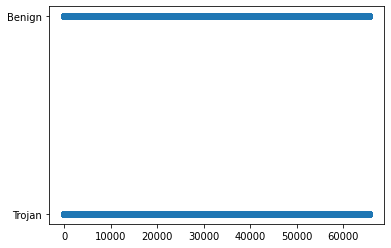

In [8]:
plt.scatter(data['SourcePort'], data['Class'])
pass

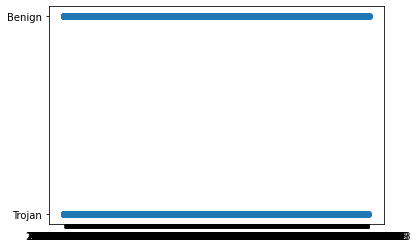

In [9]:
plt.scatter(data['SourceIP'], data['Class'])
pass

In [10]:
data.describe()

,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
count,177482.000000,177482.000000,177482.000000,1.774820e+05,177482.000000,177482.000000,177482.000000,1.774820e+05,177482.000000,177482.000000,...,177482.000000,177482.000000,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05,1.774820e+05
mean,38633.298729,5763.328969,8.295917,1.163310e+07,6.743929,9.908261,811.919496,1.023884e+04,230.168969,13.323571,...,1.673894,27.802025,1.421356e+05,2.047529e+04,1.617342e+05,1.264388e+05,4.540725e+06,4.024527e+05,4.894188e+06,4.234695e+06
std,18435.832044,15155.981517,4.540501,2.302798e+07,29.655515,106.401351,6055.745405,1.517666e+05,392.025958,67.749335,...,6.848561,6.652046,7.798898e+05,2.469821e+05,8.791481e+05,7.506803e+05,1.542957e+07,3.246955e+06,1.627581e+07,1.504980e+07
min,0.000000,0.000000,0.000000,2.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,34156.000000,80.000000,6.000000,4.690050e+04,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,43105.500000,443.000000,6.000000,4.854025e+05,2.000000,1.000000,31.000000,3.100000e+01,31.000000,0.000000,...,0.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,52135.000000,443.000000,6.000000,1.062035e+07,5.000000,4.000000,451.000000,4.950000e+02,355.000000,21.000000,...,1.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65530.000000,65267.000000,17.000000,1.199991e+08,4502.000000,12951.000000,846614.000000,1.868497e+07,1460.000000,1460.000000,...,586.000000,60.000000,3.059421e+07,1.993857e+07,4.902243e+07,3.059421e+07,1.197736e+08,7.445182e+07,1.197736e+08,1.197736e+08


### Матрица корреляций

In [11]:
corr_mat=data.corr()
corr_mat

,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
SourcePort,1.000000,-0.710282,-0.096631,0.126908,0.072241,0.032071,0.050839,0.025588,0.211155,-0.074645,...,0.092473,0.003277,0.068427,0.014634,0.063973,0.067352,0.066704,0.019887,0.066310,0.065807
DestinationPort,-0.710282,1.000000,-0.165186,-0.135386,-0.059508,-0.028456,-0.038100,-0.024242,-0.163946,0.037698,...,-0.067539,0.037283,-0.051000,-0.007334,-0.046767,-0.051467,-0.066280,-0.028509,-0.067513,-0.063390
Protocol,-0.096631,-0.165186,1.000000,-0.262353,-0.070046,-0.032686,-0.008224,-0.027739,-0.096863,0.179104,...,0.003692,0.175507,-0.072723,-0.035399,-0.073811,-0.066391,-0.151297,-0.071862,-0.155908,-0.143147
FlowDuration,0.126908,-0.135386,-0.262353,1.000000,0.123910,0.050607,0.089637,0.033185,0.238786,-0.038737,...,0.171774,-0.125844,0.325913,0.267515,0.364715,0.269939,0.733758,0.396360,0.766697,0.685770
TotalFwdPackets,0.072241,-0.059508,-0.070046,0.123910,1.000000,0.903120,0.239152,0.887999,0.215734,-0.026928,...,0.412126,-0.003054,0.156835,0.108562,0.167851,0.135763,0.096512,0.066071,0.103657,0.088171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ActiveMin,0.067352,-0.051467,-0.066391,0.269939,0.135763,0.075404,0.103488,0.062156,0.181945,0.061742,...,0.176732,0.011355,0.970865,0.034935,0.869774,1.000000,0.335270,0.103926,0.336218,0.326536
IdleMean,0.066704,-0.066280,-0.151297,0.733758,0.096512,0.033756,0.068327,0.018233,0.258082,-0.034394,...,0.149393,-0.012181,0.351814,0.121235,0.342233,0.335270,1.000000,0.231480,0.986114,0.987635
IdleStd,0.019887,-0.028509,-0.071862,0.396360,0.066071,0.020454,0.075579,0.008145,0.144475,0.036467,...,0.126240,0.005829,0.194386,0.393645,0.270594,0.103926,0.231480,1.000000,0.384021,0.078374
IdleMax,0.066310,-0.067513,-0.155908,0.766697,0.103657,0.035625,0.078558,0.018564,0.269149,-0.022404,...,0.166554,-0.010868,0.369307,0.188704,0.375905,0.336218,0.986114,0.384021,1.000000,0.949150


### Корреляции графическом виде

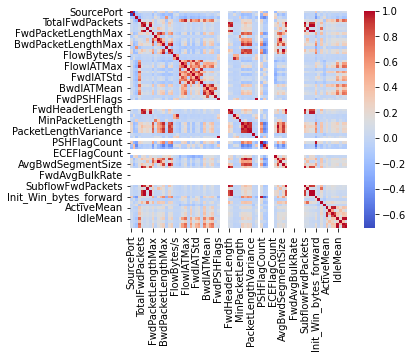

In [12]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

### Смотрим, что коррелирует

In [13]:
abs(corr_mat) > 0.9

,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
SourcePort,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
DestinationPort,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Protocol,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FlowDuration,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TotalFwdPackets,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ActiveMin,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
IdleMean,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,True
IdleStd,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
IdleMax,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,True


## Обработка текстовых данных

In [14]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
categorical_columns

['FlowID', 'SourceIP', 'DestinationIP', 'Class']

Каждое значение преобразуется в число. В данной задаче использование LabelEncoder оптимальнее OneHotEncoder.

In [15]:
from sklearn import preprocessing

data_describe = data.describe(include = [object])

number = preprocessing.LabelEncoder()

data["FlowID"] = number.fit_transform(data["FlowID"])
data["SourceIP"] = number.fit_transform(data["SourceIP"])
data["DestinationIP"] = number.fit_transform(data["DestinationIP"])

In [16]:
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object']
len(numerical_columns)

83

In [17]:
binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]

In [18]:
data['Class'].unique()

array(['Trojan', 'Benign'], dtype=object)

In [19]:
data.at[data['Class'] == 'Trojan', 'Class'] = 1
data.at[data['Class'] == 'Benign', 'Class'] = 0
data['Class'].describe()

count     177482
unique         2
top            1
freq       90683
Name: Class, dtype: int64

## Нормализация числовых данных

In [20]:
data_numerical = data[numerical_columns].astype('float32')

In [21]:
data_numerical.std(axis = 0)

FlowID             2.614904e+04
SourceIP           3.255239e+02
SourcePort         1.843583e+04
DestinationIP      9.059336e+02
DestinationPort    1.515598e+04
                       ...     
ActiveMin          7.506802e+05
IdleMean           1.542957e+07
IdleStd            3.246955e+06
IdleMax            1.627581e+07
IdleMin            1.504980e+07
Length: 83, dtype: float32

In [22]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical = data_numerical.fillna(0.0)

## Соединение всех данных

In [23]:
data = pd.concat((data_numerical, data[binary_columns]), axis = 1)
data.shape

(177482, 84)

In [24]:
data.head()

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Class
73217,-0.254680,-0.301850,0.615199,-0.551040,-0.374989,-0.505653,-0.038628,-0.092527,-0.055528,-0.072645,...,-1.172876,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,1
72089,0.846469,-0.301850,0.571479,0.048341,-0.351038,1.916987,-0.494133,-0.025086,-0.027333,0.392863,...,-1.172876,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,1
96676,-1.665593,-0.301850,-0.047966,-0.931863,-0.376771,1.916987,-0.460738,-0.193688,-0.083723,-0.129120,...,0.631080,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,0
42891,-1.619663,-0.301850,0.147468,-0.931863,-0.376771,1.916987,-0.492732,-0.193688,-0.083723,-0.127469,...,-1.172876,-0.182251,-0.082902,-0.183967,-0.168432,-0.294287,-0.123948,-0.300703,-0.281379,1
169326,-1.224047,-0.307994,0.310249,-0.696746,-0.351038,-0.505653,2.344973,0.177238,0.000862,-0.007418,...,0.631080,0.231390,-0.082902,0.182972,0.261303,3.614245,-0.123948,3.404611,3.725784,0


## Разбиение данных для обучения и тестов

In [25]:
X = data.drop('Class', axis = 1) # выбрасываем столбец 'class'
y = data['Class']

In [26]:
X = X.to_numpy()
y = np.array(y, dtype='int')

In [27]:
X.shape

(177482, 83)

In [28]:
y.shape

(177482,)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

124237 53245


## Метод K ближайших соседей, подбор n_neighbors

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
#knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# nnb = [i for i in range(1, 20)]
# knn = KNeighborsClassifier()
# grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
# grid.fit(X_train, y_train)

# best_cv_err = 1 - grid.best_score_
# best_n_neighbors = grid.best_estimator_.n_neighbors
# print(best_cv_err, best_n_neighbors)

KNeighborsClassifier(n_neighbors=10)

## Ошибки

### На тестовой выборке

In [31]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.2771152220865809

In [32]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[21227  4847]
 [ 9908 17263]]


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.68      0.81      0.74     26074
           1       0.78      0.64      0.70     27171

    accuracy                           0.72     53245
   macro avg       0.73      0.72      0.72     53245
weighted avg       0.73      0.72      0.72     53245



### На тренировочной выборке

In [34]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.22776628540611896

In [35]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, y_train_predict))

[[52346  8379]
 [19918 43594]]


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79     60725
           1       0.84      0.69      0.75     63512

    accuracy                           0.77    124237
   macro avg       0.78      0.77      0.77    124237
weighted avg       0.78      0.77      0.77    124237

